# PyDicom处理dicom文件基本流程

## 一、介绍
DICOM(DigitalImaging andCommunications inMedicine)是指医疗数字影像传输协定，是用于医学影像处理、储存、打印、传输的一组通用的标准协定。它包含了文件格式的定义以及网络通信协议。DICOM是以TCP/IP为基础的应用协定，并以TCP/IP联系各个系统。两个能接受DICOM格式的医疗仪器间，可通过DICOM格式的文件，来接收与交换影像及病人资料。

目前，DICOM被广泛应用于放射医疗，心血管成像以及放射诊疗诊断设备（X射线，CT，核磁共振，超声等），并且在眼科和牙科等其它医学领域得到越来越深入广泛的应用。
在深度学习任务中，我们需要做的就是dicom中的像素信息提取出来转化为numpy输入网络中


## 二、文件处理

### 2.1 文件读取与提取相关信息

<function matplotlib.pyplot.show(close=None, block=None)>

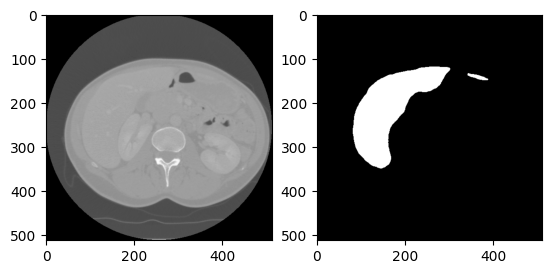

In [16]:
## 读取dicom文件
import pydicom
import matplotlib.pyplot as plt 
df1= pydicom.dcmread('./OnlyLiver/train/origin/8/image_48')
df2 = pydicom.dcmread('./OnlyLiver/train/label/8/image_48')
## 获取图像
plt.subplot(1,2,1)
img = df1.pixel_array
mask = df2.pixel_array
plt.imshow(img,'gray')
plt.subplot(1,2,2)
plt.imshow(mask,'gray')
plt.show


In [6]:
## 读取dicom信息
print("name:{}".format(df1.PatientName))
print("Patient ID:{}".format(df1.PatientID))
print("PatientSex:{}".format(df1.PatientSex))
print("StudyID:{}".format(df1.StudyID))
print('Rows:{}'.format(df1.Rows))
print("Columns:{}".format(df1.Columns))
print("图像像素间距(mm)：{}".format(df1.PixelSpacing))
print("窗位：{}".format(df1.WindowCenter))
print("窗宽：{}".format(df1.WindowWidth))
print("截取(转换CT值)：{}".format(df1.RescaleIntercept))
print("斜率(转换CT值)：{}".format(df1.RescaleSlope))

name:liver_08^patient
Patient ID:
PatientSex:M
StudyID:
Rows:512
Columns:512
图像像素间距(mm)：[0.560999989509583, 0.560999989509583]
窗位：0
窗宽：0
截取(转换CT值)：0
斜率(转换CT值)：1


## 三、文件处理

### 3.1 数据CT值转换和窗位窗宽调整

在拿到dicom图像后图像的像素一般是由CT(Hu)值组成，范围是-1024~3071，由于CT机是圆形孔径，生成的图像是矩形，其他地方会用一个很低负值(-2000或者-2048)来填充。但是图像也有可能是常见的灰度值组成。所以我觉得先读取dicom打印rescale intercept和rescale slope，看看是不是solpe=1，intercept=0，是就是由Hu组成。不是就要通过Hu = pixel * slope + intercept 进行转换成有Hu组成。

例如窗位选择50， 窗宽选择350，图像中可以显示的CT值范围就是（窗位-窗宽/2）至（窗位+窗宽/2）即-140~225，图像显示的时候只要CT值低于-140的组织都会显示黑色。CT值高于255都会显示白色。所以肝的CT值约50，要肝脏对比度显示的好，就先把窗位定在50，在选择窗宽。窗宽约大显示组织密度差别较大的结构，窗宽越窄，组织对比度强，显示密度差别较小的结构。

In [25]:
import numpy as np 
import os
from numba import jit
#读取序列
def load(dicom_path):
    #加载这个系列的切片(dicom数据集往往一个文件夹为一个系列，为不同时期同一部位的医疗影像)
    slices  = [pydicom.read_file(os.path.join(dicom_path,s),force=True) for s in os.listdir(dicom_path)]
    #按ImagePositionPatient[2]排序，否则得到的扫描面是混乱无序的
    slices.sort(key= lambda x: float(x.ImagePositionPatient[2]))
    #获取切片厚度
    slice_thick = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    #统一每个切片的厚度
    for s in slices:
        s.SliceThickness  = slice_thick
    return slices

#将像素值转化为hu值
def get_piexl_hu(slices):
    images = np.stack([s.pixel_array for s in slices])
    images = images.astype(np.int16)
    images[images == -2048] = 0
    for num in range(len(slices)):
        intercept  = slices[num].RescaleIntercept
        slope = slices[num].RescaleSlope

    if slope != 1:
        images[num] = slope * images[num].astype(np.float64)
        images[num] = images[num].astype(np.int16)
        images[num] = images[num] + np.int16(intercept)
    return images
@jit(nopython=True)
def calc(img_temp, rows, cols, minval,maxval):
    for i in np.arange(rows):
        for j in np.arange(cols):
            #避免除以0的报错
            if maxval - minval == 0:
                result = 1
            else:
                result = maxval - minval
            img_temp[i, j] = int((img_temp[i, j] - minval) / result * 255)
def setDicomWinWidthWinCenter(img_data,winwidth, wincenter):
    minval = (2*wincenter - winwidth) / 2.0 + 0.5
    maxval = (2*wincenter + winwidth) / 2.0 + 0.5
    for index in range(len(img_data)):
        img_temp = img_data[index]
        rows, cols = img_temp.shape
        # 采用numba加速计算
        calc(img_temp, rows, cols, minval, maxval)
        img_temp[img_temp < 0] = 0
        img_temp[img_temp > 255] = 255
        img_data[index] = img_temp
    return img_data

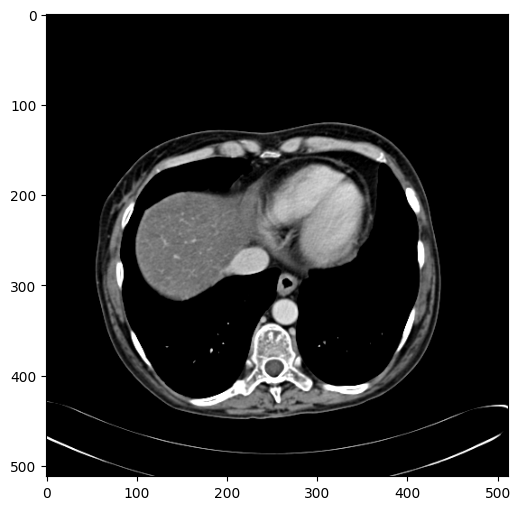

In [26]:

#显示调整窗宽窗位，以看肝脏为目标
#设置窗宽窗位
winwidth = 350
wincenter = 50
#读取整个系列dicom文件
path = './OnlyLiver/train/origin/18/'
patient = load(path)
#像素值转成CT值
patient_pixels = get_piexl_hu(patient)
#改变窗宽窗位
patient_pixels = setDicomWinWidthWinCenter(patient_pixels,winwidth,wincenter)
plt.figure(figsize=(6, 6))
plt.imshow(patient_pixels[65], 'gray')
plt.show()